In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import cv2

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

In [2]:
matplotlib.rcParams.update({'font.size': 22})

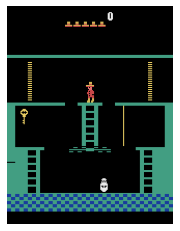

In [5]:
env = gym.make("MontezumaRevenge-v0")
env.reset()


plt.imshow(env.ale.getScreenRGB2())
plt.axis("off")
plt.show()

In [3]:
def plot_norms(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x')
        stds = np.std(ys, axis = 1)
        #plt.fill_between(x, mu + np.max(ys, axis=1) , mu - np.min(ys, axis=1), alpha=0.2, color=color)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2, color=color)
    
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_sigma.pdf', format='pdf', dpi=1000)

def plot_fgsm(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$')
        plt.ylabel('Average Reward')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, mu + stds , mu - stds, alpha=0.2)
    
    plt.xticks(rotation=-45)
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_sigma.pdf', format='pdf', dpi=1000)

In [4]:
def plot_norms_minmax(episodes):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $min/max$ interval')
    plt.xlabel('L2 Norm of Noise')
    plt.ylabel('Average Reward')
    
    for ep, color, label in episodes:
        x, ys = np.array(list(ep.keys())).astype(np.float), np.array(list(ep.values()))
        
        # normalise to the highest reward
        # y = np.mean(ep[0]) for normalising against the first data point
        #y = np.max([np.mean(ep[k]) for k in ep.keys()])
        #ys = (ys - y) / y
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=label, color=color, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('noise_minmax.pdf', format='pdf', dpi=1000)

def plot_fgsm_minmax(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    for kk in ['both', 'goal_only', 'action_only']:
        x, ys = np.array(list(episode_durations[kk].keys())), np.array(list(episode_durations[kk].values()))
        plt.xlabel('$\epsilon$')
        plt.ylabel('Average Reward')
        
        mu = np.mean(ys, axis=1)
        plt.plot(x, mu, label=kk, marker='x')
        stds = np.std(ys, axis = 1)
        plt.fill_between(x, np.max(ys, axis=1) , np.min(ys, axis=1), alpha=0.2, color=color)
    
    plt.xticks(rotation=-45)

    plt.legend(prop={'size': 14})
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('fgsm_minmax.pdf', format='pdf', dpi=1000)

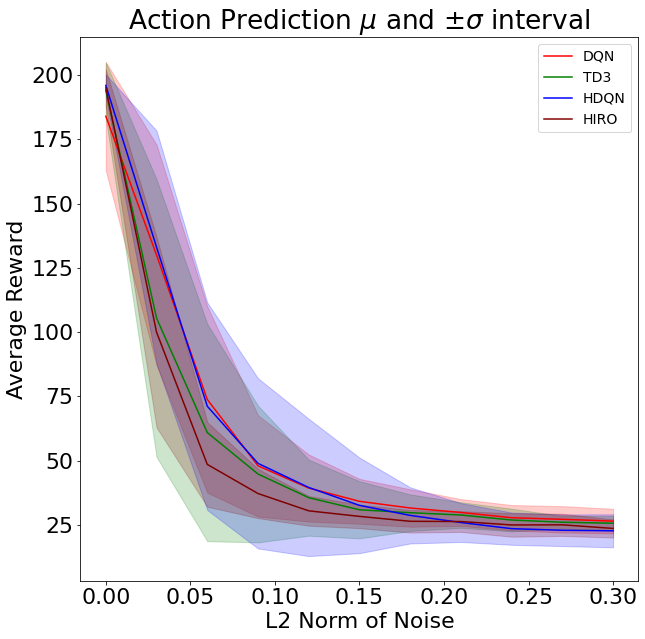

In [6]:
import json
plot_norms([\
    (json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("absolute_noise/hdqn_episodes.json")), "blue", "HDQN"),\
    (json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
   ])

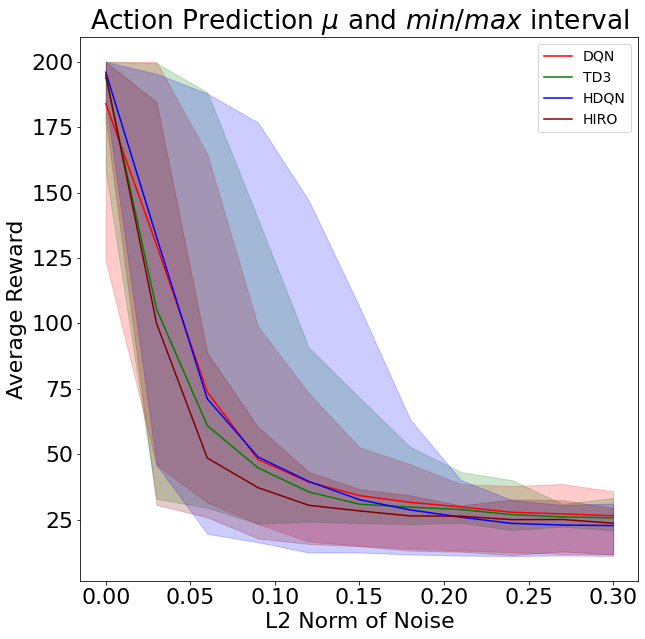

In [7]:
import json
plot_norms_minmax([\
    (json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    (json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    (json.load(open("absolute_noise/hdqn_episodes.json")), "blue", "HDQN"),\
    (json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
   ])

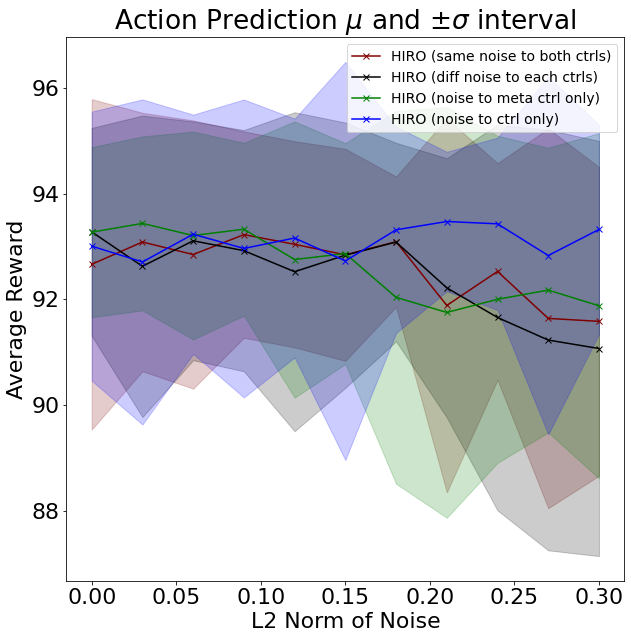

In [26]:
import json
plot_norms([\
    (json.load(open("car/noise/hiro_episodes.json")), "maroon", "HIRO (same noise to both ctrls)"),\
    (json.load(open("car/noise_diff/hiro_episodes.json")), "black", "HIRO (diff noise to each ctrls)"),\
    (json.load(open("car/noise_meta_only/hiro_episodes.json")), "green", "HIRO (noise to meta ctrl only)"),\
    (json.load(open("car/noise_ctrl_only/hiro_episodes.json")), "blue", "HIRO (noise to ctrl only)")
   ])

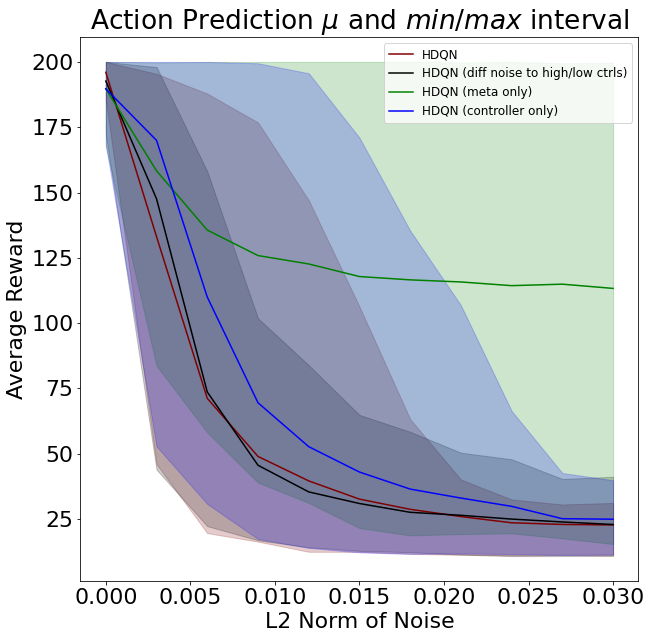

In [24]:
import json
plot_norms_minmax([\
    #(json.load(open("absolute_noise/dqn_episodes.json")), "red", "DQN"),\
    #(json.load(open("absolute_noise/td3_episodes.json")), "green", "TD3"),\
    #(json.load(open("absolute_noise/hiro_episodes.json")), "maroon", "HIRO"),\
    #(json.load(open("absolute_noise_different/hiro_episodes.json")), "black", "HIRO (diff noise to high/low ctrls)"),\
    #(json.load(open("absolute_noise_meta_only/hiro_episodes.json")), "green", "HIRO (meta only)"),\
    #(json.load(open("absolute_noise_ctrl_only/hiro_episodes.json")), "blue", "HIRO (controller only)")
    (json.load(open("absolute_noise/hdqn_episodes.json")), "maroon", "HDQN"),\
    (json.load(open("absolute_noise_different/hdqn_episodes.json")), "black", "HDQN (diff noise to high/low ctrls)"),\
    (json.load(open("absolute_noise_meta_only/hdqn_episodes.json")), "green", "HDQN (meta only)"),\
    (json.load(open("absolute_noise_ctrl_only/hdqn_episodes.json")), "blue", "HDQN (controller only)")
  ])

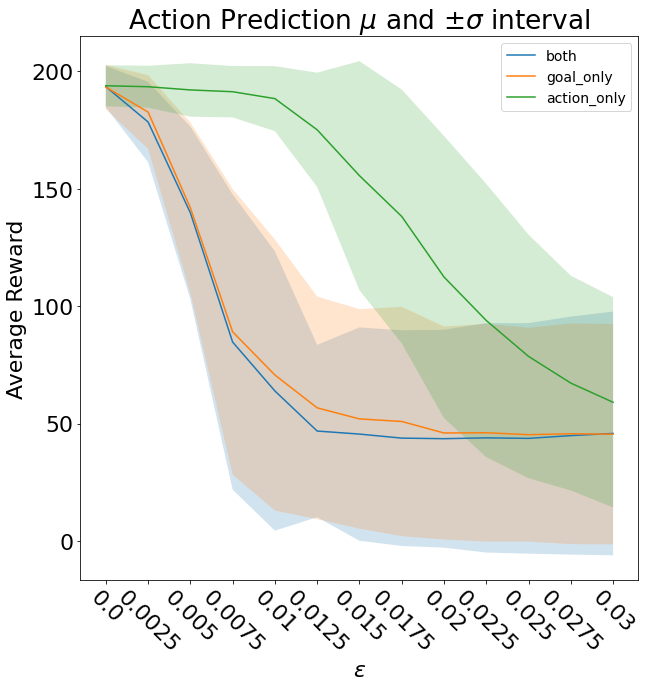

In [14]:
import json
plot_fgsm(json.load(open("fgsm_untargeted/hiro_episodes.json")))

In [17]:
hiro1 = {0.0: [94.02777673017681], 0.03: [92.02588251253998], 0.06: [93.87746940781564], 0.09: [94.04653425491328], 0.12: [93.8358224617025], 0.15: [93.88983702755105], 0.18: [93.82142706906177], 0.21: [93.93085675962612], 0.24: [94.00082507584875], 0.27: [93.9290786402619], 0.3: [93.91338916408019]}
hiro2 = {0.0: [93.56810080166315, 94.5467629045013], 0.03: [93.81159926155885, 94.6239733920926], 0.06: [93.99413432918988, 94.57913055015331], 0.09: [93.58656923877962, 94.6446265832389], 0.12: [93.5946254175048, 94.67452965298078], 0.15: [93.86829617535261, 94.58096806753603], 0.18: [93.98143723726446, 94.55165454262739], 0.21: [94.21035742563652, 94.61372203272212], 0.24: [93.5985539339974, 94.6250792352933], 0.27: [93.86400481485525, 94.63088898635208], 0.3: [93.85961094178491, 94.60651512856728]}
hiro3 = {0.0: [94.07289380280119, 93.41427742933483], 0.03: [94.20587909016955, 93.6530037620873], 0.06: [94.05065810166538, 93.68856573264273], 0.09: [93.88217628531363, 93.7651387207824], 0.12: [94.22629956635379, 93.46475102730449], 0.15: [94.14188943927807, 93.66818605838816], 0.18: [94.30907533596137, 93.69595506076737], 0.21: [94.12570888545326, 93.98998883079986], 0.24: [94.51531042564523, 93.69879714970614], 0.27: [93.92818421539681, 93.78727937154946], 0.3: [93.76291797171785, 93.81549600120368]}
hiro4 = {0.0: [93.8296301518082, 93.94819979370116, 94.54459523129128], 0.03: [94.00513693589123, 94.1946622668451, 94.34275799536076], 0.06: [93.8162477712379, 94.32515117664774, 94.47025003793418], 0.09: [94.07460384209188, 94.15079303020404, 94.53888412753471], 0.12: [93.79596031522959, 94.360072869417, 94.49435143883328], 0.15: [93.86051052797634, 94.35209029705176, 94.56963673658207], 0.18: [94.03523935141199, 94.08132076963753, 94.58269786229579], 0.21: [93.87588605996167, 92.95926039140801, 94.59467181132672], 0.24: [93.82108412162614, 94.19738286480124, 94.46135472387466], 0.27: [94.0168555981215, 94.06983188470986, 94.54330194727083], 0.3: [94.06789240747557, 94.57486635047532, 94.50682697423272]}
hiro5 = {0.0: [92.5620813146069, 85.56388258385691], 0.03: [92.41590043320002, 83.81236985481331], 0.06: [92.94137548746463, 86.58731308087856], 0.09: [92.21065157182694, 84.74248402449012], 0.12: [92.52955827734976, 86.63195049368552], 0.15: [92.80139027376993, 81.54624977558716], 0.18: [92.35267633212574, 87.75148634964164], 0.21: [92.37479462067489, 90.05189154861706], 0.24: [92.50213942780654, 88.86995691520356], 0.27: [92.73871272000237, 82.79929457927332], 0.3: [92.46199921441263, 87.65504686861814]}

In [18]:
hiro = {}
for i in hiro1.keys():
    hiro[i] = list(np.concatenate([hiro1[i], hiro2[i], hiro3[i], hiro4[i], hiro5[i]]))

In [7]:
for i in hiro1.keys():
    for ii in hiro1[i].keys():
        pass
        #hiro1[i].pop(2)
        #hiro1[i][ii].pop(5)
        #hiro1[i][ii].pop(3 - 1)
        #hiro1[i][ii].pop(10 - 2)
        #hiro1[i][ii].pop(12 - 3)
        #hiro1[i][ii].pop(18 - 4)
        #hiro2[i][ii].pop(0)
        #hiro2[i][ii] = np.array(hiro2[i][ii])[[1, 2, 3, 4, 5, 6]]
        
hiro = {}
for i in hiro1.keys():
    hiro[i] = {}
    for ii in hiro1[i].keys():
        all_i = list(np.concatenate([hiro1[i][ii], hiro2[i][ii], hiro3[i][ii], hiro4[i][ii], hiro5[i][ii]]))
        hiro[i][ii] = all_i

AttributeError: 'list' object has no attribute 'keys'

In [12]:
len(hiro['both'][0.0])

20

In [19]:
import json
json = json.dumps(hiro)
f = open("hiro_episodes.json","w")
f.write(json)
f.close()

In [9]:
import json
eps = {0.0: [-104.11, -124.67, -102.64, -102.49, -104.6, -101.87, -108.08, -107.21, -103.08, -108.37], 0.025: [-107.94, -125.12, -119.55, -100.24, -116.46, -131.76, -134.96, -113.34, -111.95, -144.3], 0.05: [-131.53, -133.64, -146.68, -114.97, -159.9, -155.75, -148.74, -151.34, -175.45, -182.84], 0.07500000000000001: [-175.02, -152.03, -174.03, -160.41, -176.16, -187.93, -150.97, -175.19, -181.02, -200.0], 0.1: [-185.89, -184.63, -176.51, -177.47, -186.28, -194.28, -170.58, -187.0, -182.34, -200.0], 0.125: [-187.25, -191.64, -174.87, -197.86, -200.0, -199.7, -200.0, -188.9, -182.7, -200.0], 0.15000000000000002: [-195.06, -200.0, -172.06, -199.96, -200.0, -200.0, -200.0, -200.0, -189.54, -200.0], 0.17500000000000002: [-200.0, -200.0, -177.99, -200.0, -200.0, -200.0, -200.0, -200.0, -199.66, -200.0], 0.2: [-200.0, -200.0, -182.42, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0], 0.225: [-200.0, -200.0, -194.57, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0], 0.25: [-200.0, -200.0, -200.0, -199.76, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0], 0.275: [-200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0], 0.30000000000000004: [-200.0, -200.0, -200.0, -199.86, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0]}
json = json.dumps(eps)
f = open("dqn_episodes.json","w")
f.write(json)
f.close()

In [14]:
import json
# both, goal_only, action_only
eps = {
    'both': json.load(open("cartpole/noise_different/hiro_episodes_old.json")),
    'action_only': json.load(open("cartpole/noise_ctrl_only/hiro_episodes_old.json")),
    'goal_only': json.load(open("cartpole/noise_meta_only/hiro_episodes_old.json"))
}
json = json.dumps(eps)
f = open("hiro_episodes_old.json","w")
f.write(json)
f.close()

***
Things for making gifs:

In [ ]:
# tricks to make rendering work in Colab
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
# goal: 0 to 1; action: 0 to 1
def append_action_goal_to_screen(img, goal, action):
    img = np.array(img[:,::-1])
    max_width = 100
    height = 50

    # omit these two lines for HIRO
    goal = goal * 2 - 1
    action = action * 2 - 1

    if goal < 0:
        cv2.rectangle(img, (int(max_width + goal * max_width), 0), (max_width, height), (255, 0, 0), -1) # goal
    else:
        cv2.rectangle(img, (max_width, 0), (int(max_width + goal * max_width), height), (255, 0, 0), -1) # goal
    if action < 0:
        cv2.rectangle(img, (int(max_width + action * max_width), height), (max_width, 2 * height), (0, 0, 255), -1) # action
    else:
        cv2.rectangle(img, (max_width, height), (int(max_width + action * max_width), 2 * height), (0, 0, 255), -1) # action
    return img

In [ ]:
def render_single_episode(hdqnAgent): # HDQN
    hdqnAgent.eval()
    hdqnAgent.meta_controller.eval()
    hdqnAgent.controller.eval()

    max_episode_length = 200
    num_episodes = 100

    frames = []

    overall_reward = 0
    observation = env.reset()

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = hdqnAgent.select_goal(state)
        goal_i = goal.item()
        encoded_goal = torch.from_numpy(one_hot(2, goal)).float().to(device)

        goal_done = False
        while not done and not goal_done:
            joint_goal_state = torch.cat([encoded_goal, state], axis=1)

            action = hdqnAgent.select_action(joint_goal_state)
            action_i = action.item()

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal_i, action_i))

            observation, reward, done, _ = env.step(action_i)

            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = (goal_i == action_i)

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
    return frames, overall_reward

In [ ]:
def render_single_episode(agent): #HIRO
    agent.eval()
    agent.meta_controller.eval()
    agent.controller.eval()

    max_episode_length = 200
    agent.meta_controller.is_training = False
    agent.controller.is_training = False

    num_episodes = 1

    frames = []

    overall_reward = 0
    observation = env.reset()
    # set a large starting angle
    env.state[2] = -env.observation_space.high[2] / 2.0
    observation = np.array(env.state)

    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    episode_steps = 0
    done = False
    while not done:
        # select a goal
        goal = agent.select_goal(state, False)

        goal_done = False
        while not done and not goal_done:
            action = agent.select_action(state, goal, False)

            frames.append(append_action_goal_to_screen(env.render(mode="rgb_array"), goal, action))

            observation, reward, done, info = env.step(action.detach().cpu().squeeze(0).numpy())

            next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            next_goal = agent.h(state, goal, next_state)
                              
            overall_reward += reward

            if max_episode_length and episode_steps >= max_episode_length - 1:
                done = True
            episode_steps += 1

            goal_done = agent.goal_reached(state, goal, next_state)

            state = next_state
            goal = next_goal
    return frames, overall_reward

In [ ]:
frames, overall_reward = render_single_episode(agent)
print(overall_reward)

import pickle
with open('frames.pkl', 'wb') as f:
    pickle.dump(frames, f)

In [ ]:
with open('frames.pkl', 'rb') as f:
    frames = pickle.load(f)
with open('openai_gym.gif', 'wb') as f:
    frames = list(map(lambda x: Image.fromarray(x), frames))
    im = Image.new('RGB', frames[0].size)
    im.save(f, save_all=True, append_images=frames)